In [1]:
# imports
import os
import math
import dill
from itertools import permutations




import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import gridspec
from sklearn.linear_model import LogisticRegression as logreg
from statsmodels.regression.mixed_linear_model import MixedLM
from pingouin import mixed_anova, anova, rm_anova, pairwise_tukey, pairwise_tests


import TwoPUtils
import STX3KO_analyses as stx
u = stx.utilities
ko_mice = stx.ymaze_sess_deets.ko_mice
ctrl_mice = stx.ymaze_sess_deets.ctrl_mice


plt.rcParams['pdf.fonttype']=42
plt.rcParams['font.family'] ='sans-serif'
plt.rcParams['font.serif'] = 'Arial'

%matplotlib inline

%load_ext autoreload
%autoreload 2

/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


$$
\begin{align} 
&P(X | \vec Y) \propto P(\vec Y | X) P(X)  = P(X) \prod_{i=0}^{M} P(Y_i| X) \\
&P(Y_i|X) \sim Gamma(Y_i; k_{i,x}) \\
&Gamma(y; k) = \frac{1}{\Gamma(k)} y^{k-1} e ^{-x} 
\end{align}
$$

$k$ is the mean dF/F at that position \\

assume $P(X)$ is uniform

In [12]:
figdir = "/mnt/BigDisk/YMazeResults/neural/naive_bayes"
os.makedirs(figdir,exist_ok=True)

In [13]:
gamma = lambda x,kappa:  1/sp.special.gamma(kappa)* np.exp(-x)*np.power(x,kappa-1)
poiss = lambda k,lam:  1/sp.special.gamma(k)* np.exp(-lam)*np.power(lam,k)

def logsumexp(x,axis=-1):
    c = x.max(axis = axis, keepdims=True) + 1E-5
    return c + np.log(np.sum(np.exp(x - c ),axis=axis, keepdims=True))

In [14]:
sess = u.load_single_day(ctrl_mice[2],0)
print(sess.trial_matrices['spks'].shape)
sess = u.load_single_day(ctrl_mice[2],4)
print(sess.trial_matrices['spks'].shape)
print((sess.trial_info['LR']!=sess.novel_arm).sum())

sess = u.load_single_day(ko_mice[2],0)
print(sess.trial_matrices['spks'].shape)
sess = u.load_single_day(ko_mice[2],4)
print(sess.trial_matrices['spks'].shape)

{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 0}
(138, 30, 1568)
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
(140, 30, 1208)
120
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
(102, 30, 936)
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
(93, 30, 1087)


In [15]:
# within day models

def crossval(sess, n_cells = -1, poisson = True, nov = False):
    
    # assuming uniform prior over bins
    if nov:
        trial_mask = sess.trial_info['LR']==sess.novel_arm
    else:
        trial_mask = sess.trial_info['LR']==-1*sess.novel_arm
        
    trial_mat = sess.trial_matrices['spks'][trial_mask,:,:]*10
    trial_mat -= np.amin(trial_mat,axis=-1,keepdims=True)
    trial_mat += 1E-3

    # select cells
    if n_cells ==-1:
#         print('all_cells')
        pass
    else:
        rng = np.random.default_rng()
        trial_mat = trial_mat[:,:,rng.permutation(trial_mat.shape[-1])[:n_cells]]
    
    posterior = np.zeros([trial_mat.shape[0], trial_mat.shape[1], trial_mat.shape[1]])
    for trial in range(trial_mat.shape[0]):
        
        mask = np.zeros((trial_mat.shape[0],))<1
        mask[trial] = False
        
        trial_mat_mean = np.nanmean(trial_mat[mask,:,:],axis=0)
        
        y = np.copy(trial_mat[trial,:,:])
        y[np.isnan(y)]=1E-3
        log_likelihood = 0
        for cell in range(trial_mat.shape[-1]):
            if poiss:
                log_likelihood += np.log(poiss(y[:,cell:cell+1], trial_mat_mean[:,cell:cell+1].T)+1E-3)
            else:
                log_likelihood += np.log(gamma(y[:,cell:cell+1], trial_mat_mean[:,cell:cell+1].T)+1E-3)
        
        posterior[trial,:,:] = np.exp(log_likelihood - logsumexp(log_likelihood))
        

    
    return posterior


def test(_y, trial_mat_mean, poisson=False):
    log_likelihood = 0
    for cell in range(trial_mat_mean.shape[-1]):
        yc, tmm = _y[:,cell], trial_mat_mean[:,cell]
        if poisson:
            log_likelihood += np.log(poiss(yc[:,np.newaxis], tmm[np.newaxis,:])+1E-3)
        else:
            log_likelihood += np.log(gamma(yc[:,np.newaxis], tmm[np.newaxis,:])+1E-3)
    return np.exp(log_likelihood - logsumexp(log_likelihood))
        

        

{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '22_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 4}


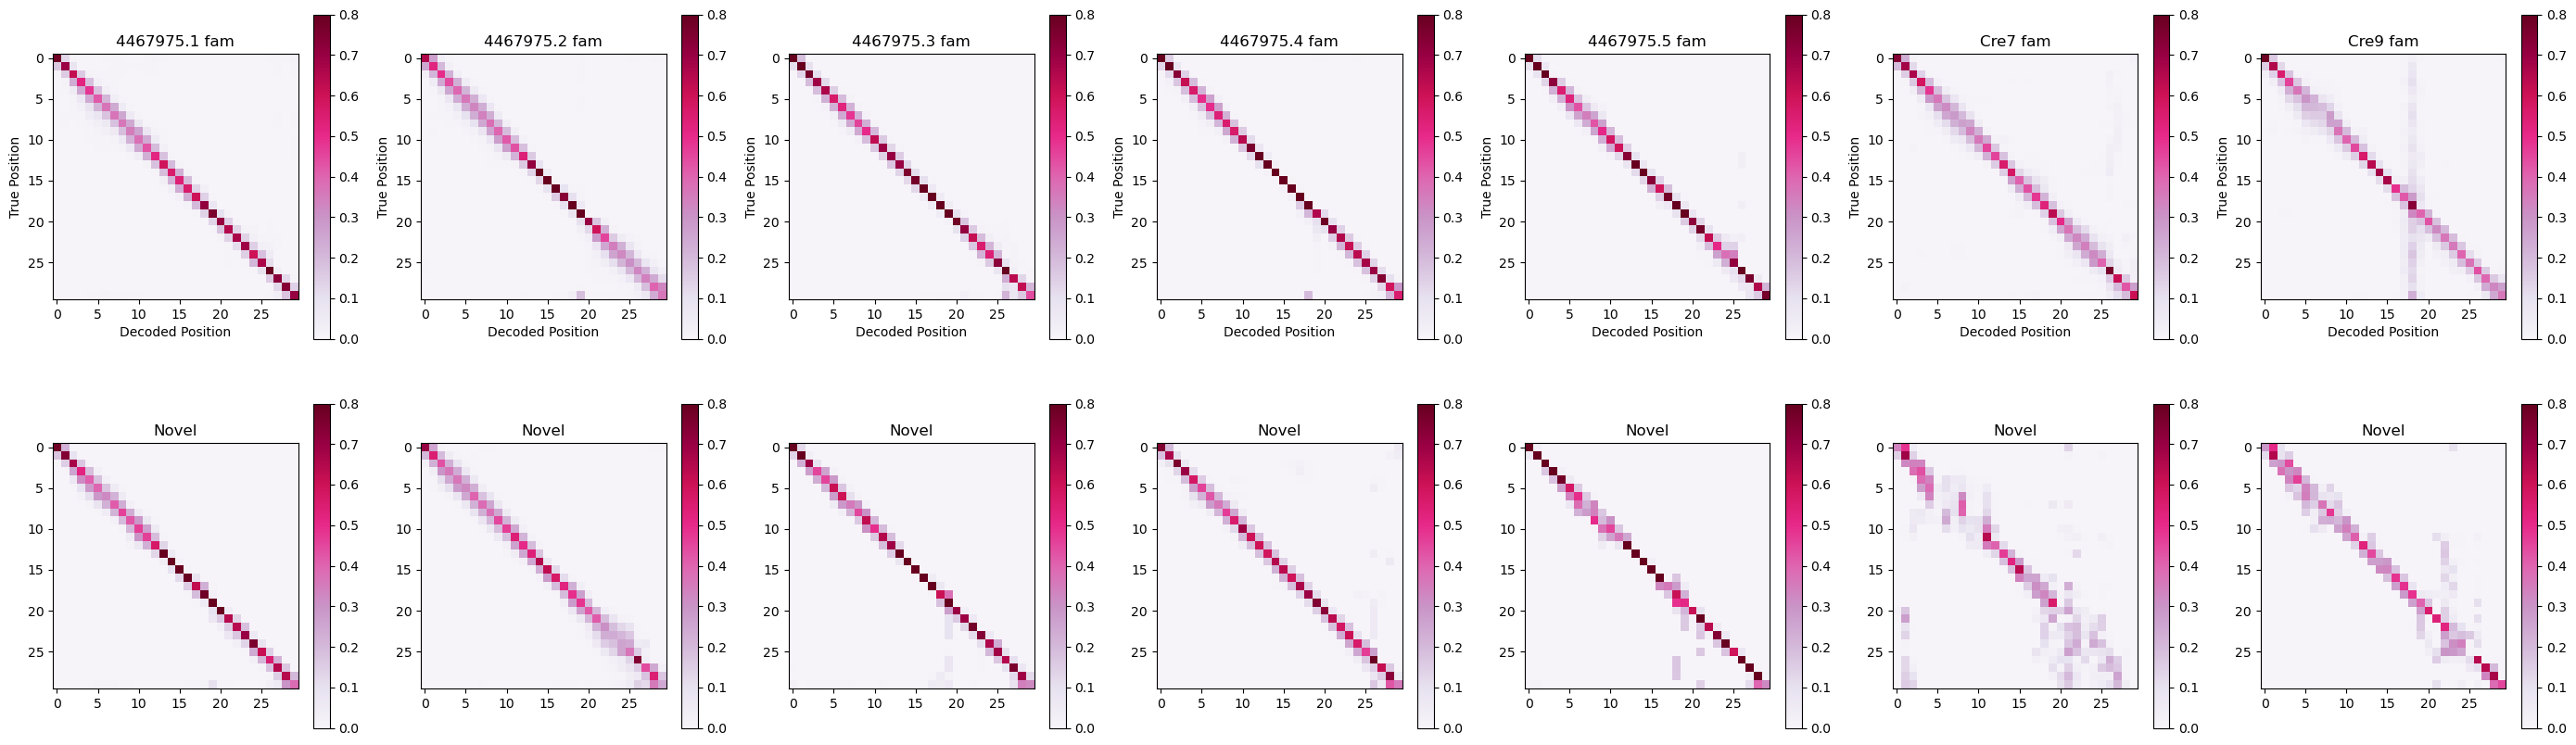

In [8]:
fig, ax = plt.subplots(2,len(ko_mice), figsize= [5*len(ko_mice),10])
for m, mouse in enumerate(ko_mice):
    sess = u.load_single_day(mouse,4)
    fam_post = crossval(sess,nov=False)
    nov_post = crossval(sess,nov=True)
    
    h = ax[0,m].imshow(fam_post.mean(axis=0), cmap='PuRd', vmin=0,vmax=.8)
    plt.colorbar(h, ax = ax[0,m])
    h = ax[1,m].imshow(nov_post.mean(axis=0), cmap='PuRd', vmin=0,vmax=.8)
    plt.colorbar(h, ax = ax[1,m])
    ax[0,m].set_title("%s fam" % mouse)
    ax[0,m].set_xlabel('Decoded Position')
    ax[0,m].set_ylabel('True Position')
    
    ax[1,m].set_title("Novel")
fig.savefig(os.path.join(figdir, "KO_day4_famnov.pdf"), format= 'pdf')

{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}


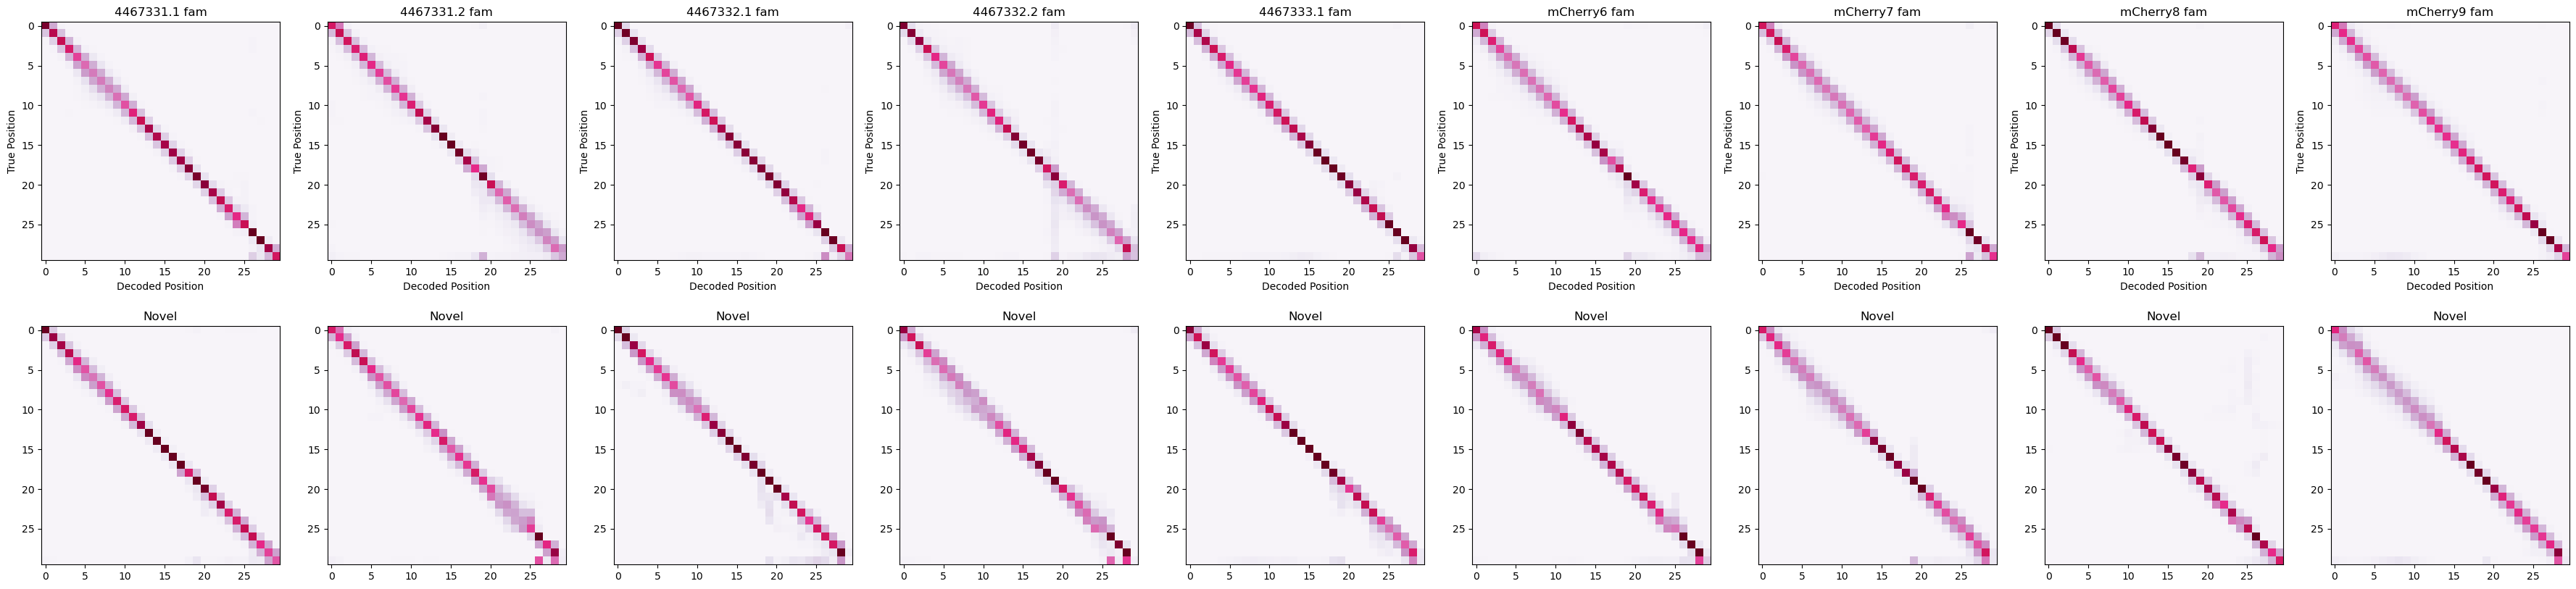

In [9]:
fig, ax = plt.subplots(2,len(ctrl_mice), figsize= [5*len(ctrl_mice),10])
for m, mouse in enumerate(ctrl_mice):
    sess = u.load_single_day(mouse,4)
    fam_post = crossval(sess,nov=False)
    nov_post = crossval(sess,nov=True)
    
    ax[0,m].imshow(fam_post.mean(axis=0), cmap='PuRd', vmin=0,vmax=.8)
    ax[1,m].imshow(nov_post.mean(axis=0), cmap='PuRd', vmin=0,vmax=.8)
    ax[0,m].set_title("%s fam" % mouse)
    ax[0,m].set_xlabel('Decoded Position')
    ax[0,m].set_ylabel('True Position')
    
    ax[1,m].set_title("Novel")
# fig.savefig(os.path.join(figdir, "CTRL_day4_famnov.pdf"), format= 'pdf')

In [16]:
# decoding error as a function of position
def err_metrics(post):
    err = np.zeros([*post.shape[:2]])*np.nan
    unc = np.zeros([*post.shape[:2]])*np.nan
    true_pos = np.arange(0,post.shape[1])
    for trial in range(post.shape[0]):
        decode_pos = np.argmax(post[trial,:,:],axis=-1)
        err[trial,:] = np.abs(decode_pos-true_pos)
        unc[trial,:] = sp.stats.entropy(post[trial,:,:],axis=-1)
    return err, unc
    
    


In [17]:
# sub sample cells to match N

# for n_cells in [8, 16, 32, 64, 128, 256, ]
def run_ncells_baseline_crossval(mice, day = 0):
    results = {}
    for mouse in mice:
        print('mouse', mouse)
        results[mouse]={}
        sess = u.load_single_day(mouse,day=day)
        for n_cells in [2**n for n in range(3,9)]:
            print('n cells', n_cells)
            fam_post = []
            nov_post = []
            for rep in range(50):
                fam_post.append(crossval(sess,n_cells=n_cells, nov=False))
                nov_post.append(crossval(sess,n_cells=n_cells, nov = True))
            fam_post = np.concatenate(fam_post,axis=0)
            nov_post = np.concatenate(nov_post,axis=0)
            results[mouse][n_cells]={'fam': fam_post, 'nov':nov_post}
    return results

def run_alldays_baseline_crossval(mice, n_cells):
    results = {}
    for mouse in mice:
        print('mouse', mouse)
        results[mouse]={}
        for day in range(6):
            results[mouse][day]={}
            sess = u.load_single_day(mouse,day=day)
            
            fam_post = []
            nov_post = []
            for rep in range(50):
                fam_post.append(crossval(sess,n_cells=n_cells, nov=False))
                nov_post.append(crossval(sess, n_cells=n_cells, nov=True))
            fam_post = np.concatenate(fam_post, axis=0)
            nov_post = np.concatenate(nov_post, axis=0)
            
            results[mouse][day] = {'fam': fam_post, 'nov': nov_post}
    return results
                                
        

# ko_ncells_crossval = run_ncells_baseline_crossval(ko_mice, day = 4)
# ctrl_ncells_crossval = run_ncells_baseline_crossval(ctrl_mice, day = 4)

In [18]:
ko_ncells_crossval = run_ncells_baseline_crossval(ko_mice, day = 0)
ctrl_ncells_crossval = run_ncells_baseline_crossval(ctrl_mice, day = 0)

mouse 4467975.1
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1}
n cells 8
n cells 16
n cells 32
n cells 64
n cells 128
n cells 256
mouse 4467975.2
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}
n cells 8
n cells 16
n cells 32
n cells 64
n cells 128
n cells 256
mouse 4467975.3
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
n cells 8
n cells 16
n cells 32
n cells 64
n cells 128
n cells 256
mouse 4467975.4
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
n cells 8
n cells 16
n cells 32
n cells 64
n cells 128
n cells 256
mouse 4467975.5
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
n cells 8
n cells 16
n cells 32
n cells 64
n cells 128
n cells 256
mouse Cre7
{'date': '18_10_2021', 'scene': 'YMaze_LNovel

KeyboardInterrupt: 

In [ ]:
df = {
     'ko': [],
     'ncells': [],
     'nov': [],
     'err': [],
     'mouse': [],
     }

s=40
lw=8

n_cells = np.array([2**n for n in range(3,9)])
n_cells_z = np.log2(n_cells)/np.log2(n_cells[-1])

fig,ax = plt.subplots(1,2, sharey=True, figsize =[15,5])

ko_fam = np.zeros((len(ko_mice), n_cells.shape[0]))
ctrl_fam = np.zeros((len(ctrl_mice), n_cells.shape[0]))

ko_nov = np.zeros((len(ko_mice), n_cells.shape[0]))
ctrl_nov = np.zeros((len(ctrl_mice), n_cells.shape[0]))
for i, _n_cells in enumerate(ko_ncells_crossval['4467975.1'].keys()):
    _err = []
    for m, mouse in enumerate(ko_mice):
        base_err, base_unc = err_metrics(ko_ncells_crossval[mouse][_n_cells]['fam'])
        _err.append(base_err.mean())
        df['mouse'].append(mouse)
        df['ko'].append(True)
        df['nov'].append(False)
        df['err'].append(base_err.mean())
        df['ncells'].append( _n_cells)
        
                        
    ax[0].scatter(5*np.log2(_n_cells)+1 + np.linspace(-.05,.05, num = len(ko_mice)),_err,color='red', s= 20, zorder=0)
    ax[0].plot(5*np.log2(_n_cells)  +1 + np.array([-0.4,0.4]), np.array(_err).mean()*np.ones([2,]), color='red', linewidth = lw, alpha = .3, zorder=1)
    
    _err = []
    for m, mouse in enumerate(ctrl_mice):
        base_err, base_unc = err_metrics(ctrl_ncells_crossval[mouse][_n_cells]['fam'])
        _err.append(base_err.mean())
        df['mouse'].append(mouse)
        df['ko'].append(False)
        df['nov'].append(False)
        df['err'].append(base_err.mean())
        df['ncells'].append( _n_cells)
        
    ax[0].scatter(5*np.log2(_n_cells)- 1 + np.linspace(-.05,.05, num = len(ctrl_mice))  ,_err,color='black', s=20)
    ax[0].plot(5*np.log2(_n_cells)  - 1 + np.array([-0.4,0.4]), np.array(_err).mean()*np.ones([2,]), color='black', linewidth = lw, alpha = .3, zorder=1)
    
    _err = []
    for m, mouse in enumerate(ko_mice):
        base_err, base_unc = err_metrics(ko_ncells_crossval[mouse][_n_cells]['nov'])
        _err.append(base_err.mean())
        df['mouse'].append(mouse)
        df['ko'].append(True)
        df['nov'].append(True)
        df['err'].append(base_err.mean())
        df['ncells'].append( _n_cells)
        
    ax[1].scatter(5*np.log2(_n_cells)+1 + np.linspace(-.05,.05, num = len(ko_mice)),_err,color='red', s= 20, alpha = 1)
    ax[1].plot(5*np.log2(_n_cells)  +1 + np.array([-0.4,0.4]), np.array(_err).mean()*np.ones([2,]), color='red', linewidth = lw, alpha = .3, zorder=1)
    
    _err = []
    for m, mouse in enumerate(ctrl_mice):
        base_err, base_unc = err_metrics(ctrl_ncells_crossval[mouse][_n_cells]['nov'])
        _err.append(base_err.mean())
        df['mouse'].append(mouse)
        df['ko'].append(False)
        df['nov'].append(True)
        df['err'].append(base_err.mean())
        df['ncells'].append( _n_cells)
    
    ax[1].scatter(5*np.log2(_n_cells)- 1 + np.linspace(-.05,.05, num = len(ctrl_mice))  ,_err,color='black', s= 20, alpha = 1)
    ax[1].plot(5*np.log2(_n_cells) - 1 + np.array([-0.4,0.4]), np.array(_err).mean()*np.ones([2,]), color='black', linewidth = lw, alpha = .3, zorder=1)
    
df = pd.DataFrame(df)
ax[0].set_title('Familiar Trials')
ax[1].set_title('Novel Trails')
    
for a in range(2):
    ax[a].set_xticks(5*np.arange(3,9) + .5)
    ax[a].set_xticklabels(np.arange(3,9))
    
    ax[a].set_xlabel('log2 number of cells')
    ax[a].set_ylabel('decoding error')
    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)
fig.savefig(os.path.join(figdir,'day0_ncells_baseline_crossval_error.pdf'))


In [ ]:
from pingouin import mixed_anova, anova, rm_anova, pairwise_tukey, pairwise_tests

aov =df[(df['nov']==0)].mixed_anova(dv='err', between='ko', within='ncells', subject='mouse')
print(aov)

ph = pairwise_tests(df[df['nov']==0], dv='err', between='ko', within='ncells', subject='mouse',
                     padjust='holm',parametric=True)
print(ph)

aov =df[(df['nov']==1)].mixed_anova(dv='err', between='ko', within='ncells', subject='mouse')
print(aov)

ph = pairwise_tests(df[df['nov']==1], dv='err', between='ko', within='ncells', subject='mouse',
                     padjust='holm',parametric=True)
print(ph)

# df_fam = df[df['nov']==0]
# for n in n_cells:
#     print('Cells %d' % n)
#     stats = pairwise_ttests(data=df_fam[df_fam['ncells'] == n], dv='err', between='ko')
#     print(stats)

In [ ]:
ko_ncells_crossval = run_ncells_baseline_crossval(ko_mice, day = 5)
ctrl_ncells_crossval = run_ncells_baseline_crossval(ctrl_mice, day = 5)

In [ ]:
df = {
     'ko': [],
     'ncells': [],
     'nov': [],
     'err': [],
     'mouse': [],
     }

s=40
lw=8

n_cells = np.array([2**n for n in range(3,9)])
n_cells_z = np.log2(n_cells)/np.log2(n_cells[-1])

fig,ax = plt.subplots(1,2, sharey=True, figsize =[15,5])

ko_fam = np.zeros((len(ko_mice), n_cells.shape[0]))
ctrl_fam = np.zeros((len(ctrl_mice), n_cells.shape[0]))

ko_nov = np.zeros((len(ko_mice), n_cells.shape[0]))
ctrl_nov = np.zeros((len(ctrl_mice), n_cells.shape[0]))
for i, _n_cells in enumerate(ko_ncells_crossval['4467975.1'].keys()):
    _err = []
    for m, mouse in enumerate(ko_mice):
        base_err, base_unc = err_metrics(ko_ncells_crossval[mouse][_n_cells]['fam'])
        _err.append(base_err.mean())
        df['mouse'].append(mouse)
        df['ko'].append(True)
        df['nov'].append(False)
        df['err'].append(base_err.mean())
        df['ncells'].append( _n_cells)
        
                        
    ax[0].scatter(5*np.log2(_n_cells)+1 + np.linspace(-.05,.05, num = len(ko_mice)),_err,color='red', s= 20, zorder=0)
    ax[0].plot(5*np.log2(_n_cells)  +1 + np.array([-0.4,0.4]), np.array(_err).mean()*np.ones([2,]), color='red', linewidth = lw, alpha = .3, zorder=1)
    
    _err = []
    for m, mouse in enumerate(ctrl_mice):
        base_err, base_unc = err_metrics(ctrl_ncells_crossval[mouse][_n_cells]['fam'])
        _err.append(base_err.mean())
        df['mouse'].append(mouse)
        df['ko'].append(False)
        df['nov'].append(False)
        df['err'].append(base_err.mean())
        df['ncells'].append( _n_cells)
        
    ax[0].scatter(5*np.log2(_n_cells)- 1 + np.linspace(-.05,.05, num = len(ctrl_mice))  ,_err,color='black', s=20)
    ax[0].plot(5*np.log2(_n_cells)  - 1 + np.array([-0.4,0.4]), np.array(_err).mean()*np.ones([2,]), color='black', linewidth = lw, alpha = .3, zorder=1)
    
    _err = []
    for m, mouse in enumerate(ko_mice):
        base_err, base_unc = err_metrics(ko_ncells_crossval[mouse][_n_cells]['nov'])
        _err.append(base_err.mean())
        df['mouse'].append(mouse)
        df['ko'].append(True)
        df['nov'].append(True)
        df['err'].append(base_err.mean())
        df['ncells'].append( _n_cells)
        
    ax[1].scatter(5*np.log2(_n_cells)+1 + np.linspace(-.05,.05, num = len(ko_mice)),_err,color='red', s= 20, alpha = 1)
    ax[1].plot(5*np.log2(_n_cells)  +1 + np.array([-0.4,0.4]), np.array(_err).mean()*np.ones([2,]), color='red', linewidth = lw, alpha = .3, zorder=1)
    
    _err = []
    for m, mouse in enumerate(ctrl_mice):
        base_err, base_unc = err_metrics(ctrl_ncells_crossval[mouse][_n_cells]['nov'])
        _err.append(base_err.mean())
        df['mouse'].append(mouse)
        df['ko'].append(False)
        df['nov'].append(True)
        df['err'].append(base_err.mean())
        df['ncells'].append( _n_cells)
    
    ax[1].scatter(5*np.log2(_n_cells)- 1 + np.linspace(-.05,.05, num = len(ctrl_mice))  ,_err,color='black', s= 20, alpha = 1)
    ax[1].plot(5*np.log2(_n_cells) - 1 + np.array([-0.4,0.4]), np.array(_err).mean()*np.ones([2,]), color='black', linewidth = lw, alpha = .3, zorder=1)
    
df = pd.DataFrame(df)
ax[0].set_title('Familiar Trials')
ax[1].set_title('Novel Trails')
    
for a in range(2):
    ax[a].set_xticks(5*np.arange(3,9) + .5)
    ax[a].set_xticklabels(np.arange(3,9))
    
    ax[a].set_xlabel('log2 number of cells')
    ax[a].set_ylabel('decoding error')
    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)
fig.savefig(os.path.join(figdir,'day5_ncells_baseline_crossval_error.pdf'))

In [ ]:
aov = mixed_anova(data=df[(df['nov']==0)], dv='err', between='ko', within='ncells', subject='mouse')
print(aov)

ph = pairwise_tests(df[df['nov']==0], dv='err', between='ko', within='ncells', subject='mouse',
                     padjust='bonf',parametric=True)
print(ph)

aov = mixed_anova(data=df[(df['nov']==1)], dv='err', between='ko', within='ncells', subject='mouse')
print(aov)

ph = pairwise_tests(df[df['nov']==1], dv='err', between='ko', within='ncells', subject='mouse',
                     padjust='bonf',parametric=True)
print(ph)

In [ ]:
ctrl_alldays_crossval = run_alldays_baseline_crossval(ctrl_mice, 128)
ko_alldays_crossval = run_alldays_baseline_crossval(ko_mice, 128)

In [ ]:
df = {
     'ko': [],
     'day': [],
     'nov': [],
     'err': [],
     'mouse': [],
     }

s=40
lw=8

days = np.arange(6)


fig,ax = plt.subplots(1,2, sharey=True, figsize =[15,5])

ko_fam = np.zeros((len(ko_mice), days.shape[0]))
ctrl_fam = np.zeros((len(ctrl_mice), days.shape[0]))

ko_nov = np.zeros((len(ko_mice), days.shape[0]))
ctrl_nov = np.zeros((len(ctrl_mice), days.shape[0]))

for i, day in enumerate(days):
    _err = []
    for m, mouse in enumerate(ko_mice):
        
        base_err, base_unc = err_metrics(ko_alldays_crossval[mouse][day]['fam'])
        _err.append(base_err.mean())
        df['mouse'].append(mouse)
        df['ko'].append(True)
        df['nov'].append(False)
        df['err'].append(base_err.mean())
        df['day'].append(day)
        
                        
    ax[0].scatter(5*day+1 + np.linspace(-.05,.05, num = len(ko_mice)),_err,color='red', s= 20, zorder=0)
    ax[0].plot(5*day  +1 + np.array([-0.4,0.4]), np.array(_err).mean()*np.ones([2,]), color='red', linewidth = lw, alpha = .3, zorder=1)
    
    _err = []
    for m, mouse in enumerate(ctrl_mice):
        base_err, base_unc = err_metrics(ctrl_alldays_crossval[mouse][day]['fam'])
        _err.append(base_err.mean())
        df['mouse'].append(mouse)
        df['ko'].append(False)
        df['nov'].append(False)
        df['err'].append(base_err.mean())
        df['day'].append(day)
        
    ax[0].scatter(5*day - 1 + np.linspace(-.05,.05, num = len(ctrl_mice))  ,_err,color='black', s=20)
    ax[0].plot(5*day  - 1 + np.array([-0.4,0.4]), np.array(_err).mean()*np.ones([2,]), color='black', linewidth = lw, alpha = .3, zorder=1)
    
    _err = []
    for m, mouse in enumerate(ko_mice):
        base_err, base_unc = err_metrics(ko_alldays_crossval[mouse][day]['nov'])
        _err.append(base_err.mean())
        df['mouse'].append(mouse)
        df['ko'].append(True)
        df['nov'].append(True)
        df['err'].append(base_err.mean())
        df['day'].append( day)
        
    ax[1].scatter(5*day + 1 + np.linspace(-.05,.05, num = len(ko_mice)),_err,color='red', s= 20, alpha = 1)
    ax[1].plot(5*day  + 1 + np.array([-0.4,0.4]), np.array(_err).mean()*np.ones([2,]), color='red', linewidth = lw, alpha = .3, zorder=1)
    
    _err = []
    for m, mouse in enumerate(ctrl_mice):
        base_err, base_unc = err_metrics(ctrl_alldays_crossval[mouse][day]['nov'])
        _err.append(base_err.mean())
        df['mouse'].append(mouse)
        df['ko'].append(False)
        df['nov'].append(True)
        df['err'].append(base_err.mean())
        df['day'].append( day)
    
    ax[1].scatter(5*day- 1 + np.linspace(-.05,.05, num = len(ctrl_mice))  ,_err,color='black', s= 20, alpha = 1)
    ax[1].plot(5*day - 1 + np.array([-0.4,0.4]), np.array(_err).mean()*np.ones([2,]), color='black', linewidth = lw, alpha = .3, zorder=1)
    
df = pd.DataFrame(df)
ax[0].set_title('Familiar Trials')
ax[1].set_title('Novel Trails')
    
for a in range(2):
    ax[a].set_xticks(5*days + .5)
    ax[a].set_xticklabels(days)
    
    ax[a].set_xlabel('day')
    ax[a].set_ylabel('decoding error')
    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)
fig.savefig(os.path.join(figdir,'alldays_128cells_crossval_error.pdf'))

In [ ]:
aov = mixed_anova(data=df[(df['nov']==0)], dv='err', between='ko', within='day', subject='mouse')
print(aov)

ph = pairwise_tests(df[df['nov']==0], dv='err', between='ko', within='day', subject='mouse',
                     padjust='holm',parametric=True)
print(ph)

aov = mixed_anova(data=df[(df['nov']==1)], dv='err', between='ko', within='day', subject='mouse')
print(aov)

ph = pairwise_tests(df[df['nov']==1], dv='err', between='ko', within='day', subject='mouse',
                     padjust='holm',parametric=True)
print(ph)

In [ ]:
aov = rm_anova(data=df[(df['ko']==0)*(df['nov']==0)], dv='err', within='day', subject='mouse')
print(aov)

ph = pairwise_tests(df[(df['ko']==0)*(df['nov']==0)], dv='err', within='day', subject='mouse',
                     padjust='holm',parametric=True)

print(ph)

In [ ]:
aov = rm_anova(data=df[(df['ko']==0)*(df['nov']==1)], dv='err', within='day', subject='mouse')
print(aov)

ph = pairwise_tests(df[(df['ko']==0)*(df['nov']==1)], dv='err', within='day', subject='mouse',
                     padjust='holm',parametric=True)

print(ph)

In [ ]:
aov = rm_anova(data=df[(df['ko']==1)*(df['nov']==0)], dv='err', within='day', subject='mouse')
print(aov)

ph = pairwise_tests(df[(df['ko']==1)*(df['nov']==0)], dv='err', within='day', subject='mouse',
                     padjust='holm',parametric=True)

print(ph)

In [ ]:
aov = rm_anova(data=df[(df['ko']==1)*(df['nov']==1)], dv='err', within='day', subject='mouse')
print(aov)

ph = pairwise_tests(df[(df['ko']==1)*(df['nov']==1)], dv='err', within='day', subject='mouse',
                     padjust='holm',parametric=True)

print(ph)

In [ ]:
# plot err as a function of number of cells for different models
fig,ax = plt.subplots()
for i, n_cells in enumerate(ko_ncells_crossval['4467975.1'].keys()):
    _err = []
    for mouse in ko_ncells_crossval.keys():
        base_err, base_unc = err_metrics(ko_ncells_crossval[mouse][n_cells])
        _err.append(base_err.mean())
    ax.scatter(np.log2(n_cells*np.ones([5,])),_err,color='red')
    
    _err = []
    for mouse in ctrl_ncells_crossval.keys():
        base_err, base_unc = err_metrics(ctrl_ncells_crossval[mouse][n_cells])
        _err.append(base_err.mean())
    ax.scatter(np.log2(n_cells*np.ones([5,]))+.25,_err,color='black')
ax.set_xlabel('log2 number of cells')
ax.set_ylabel('decoding error')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(os.path.join(figdir,'day0_ncells_baseline_crossval_error.pdf'))

# scatter()
fig,ax = plt.subplots()
for i, n_cells in enumerate(ko_ncells_crossval['4467975.1'].keys()):
    _err = []
    for mouse in ko_ncells_crossval.keys():
        base_err, base_unc = err_metrics(ko_ncells_crossval[mouse][n_cells])
        _err.append(base_unc.mean())
    ax.scatter(np.log2(n_cells*np.ones([5,])),_err,color='red')
    
    _err = []
    for mouse in ctrl_ncells_crossval.keys():
        base_err, base_unc = err_metrics(ctrl_ncells_crossval[mouse][n_cells])
        _err.append(base_unc.mean())
    ax.scatter(np.log2(n_cells*np.ones([5,]))+.25,_err,color='black')
ax.set_xlabel('log2 number of cells')
ax.set_ylabel('decoding entropy')